## Least Cost Pipeline Construction
This notebook imports the cost distance stack generated by `Create-Cost-Stack.ipynb` and a pipeline raster to compute a least cost "feeder" pipeline configuration. The workflow for this process is:
1. Import the stack of cost distance layers (one for each biogas source): $arr\_stack$.
1. Import the pipeline raster, setting non-pipeline cells to NaN: $arr\_pipeline$.
1. Determine which pixel among the pipeline pixels has the least cost among all farm cost distances rasters. This will serve as the location of the connection point to the existing pipeline: $C_0$.
1. Determine which farm is the source of this minimum point, done by finding which layer (in the stack of cost distance rasters) has the minimum value at that location. This represents the least cost biogas source: $F_0$.
1. Compute the least cost path connecting that farm ($F_0$) to the connection point ($C_0$): $LCP_0$.
1. Update the connection point layer ($C_0$) to include the least cost path ($LCP_0$): $Pipes_0$.
1. Remove the layer associated with $F_0$ from the stack of cost distance rasters ($arr\_CDsk$) and repeat steps 4-7:
    * Locate the minimim value among all remaining cost distance rasters to cells in the Pipes layer ($C_i$)...
    * Idenfity the source farm associated with this minimum ($F_i$)...
    * Compute the least cost path from from $F_i$ to $C_i$...
    * Update the connection point layer ($Pipes_{i+1}$)...

In [1]:
#Import packages
import numpy as np
import pandas as pd
from skimage import graph
from osgeo import gdal
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read the cost and cost distance stacks
arrCosts = np.load('../data/DuplinCostStack.npy')
arrStack = np.load('../data/DuplinStack.npy')
#dims = arrStack.shape
#print("There are {0} layers in the stack ({1} rows x {2} cols)".format(dims[0],dims[1],dims[2]))

In [3]:
#Read in the pipeline rasters
ds =  gdal.Open('../data/processed/duplin_pipe_diameter.tif')
#Get the raster projection
ds_prj = ds.GetProjection()
#Get raster attributes
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array; divide by 100 to scale as a percentage
arrPipesAll = np.array(ds.GetRasterBand(1).ReadAsArray())
#Convert to a masked array (ignoring all values < 0, which are NoData)
arrPipes = np.ma.masked_array(arrPipesAll, mask=arrPipesAll < 0)
#Print info
#print("Lower left coordinate = ({0:.8f},{1:.8f})".format(llx,lly))
#print("Pixel size is {0:.8f}(x), {1:.8f}(y)".format(x_size,y_size))
#print("Values range from {} to {}".format(arrPipes.min(),arrPipes.max()))

Find the least cost farm location occurring among the pipeline pixels. This is done by:
 1. Reducing the stack of cost distance layers to a single layer of the minimum value at each location (`arrMin`). 
 1. From this layer, pixels that don't coincide with pipeline locations are masked out (`arrMin_masked`), and 
 1. The minimum cost distance layer is extracted from the remaining pixels; this is the lowest cost pipeline pixel (`minValue`). 
 1. The row and column indices corresponding to that minimum value are determined (`rowMin` and `colMin`). 
 1. All layers in the stack of cost distance layers are searched at that row/column coordinate to determine which layer has that minimum value (`layerMin`)

In [9]:
#Reduce the stack of cost distance layers to minimum values
arrMin = np.amin(arrStack,axis=0)
#Mask the values so only pipeline pixels are kept
arrMin_masked = np.ma.masked_array(arrMin, mask=arrPipesAll < 0)
#Find the min value of the pipeline pixels
minValue = np.amin(arrMin_masked)
#Determine the row and column where the min occurs
rMin,cMin = np.where(arrMin_masked == minValue)
rowMin = rMin[0]
colMin = cMin[0]
#Find which layer has the min value at this location in the stack of layers
[layerMin] = np.where(arrStack[:,91,48] == minValue)[0]
print("Min CD:\t\t{0:.4f}\nRow/Col:\t({1},{2})\nLayer:\t\t{3}".format(minValue,rowMin,colMin,layerMin))

Min CD:		2.5359
Row/Col:	(91,48)
Layer:		0


Compute the LCP from that farm to the pipeline

In [10]:
#Find the farm location, will be min in the layer identified above
arrSource = arrStack[layerMin]
rFarm,cFarm = np.where(arrStack[layerMin,:,:]==np.amin(arrStack[0,:,:]))
rowFarm = rFarm[0]
colFarm = cFarm[0]
print("The farm occurs at (row={}, col={})".format(rowFarm,colFarm))

The farm occurs at (row=114, col=63)


In [46]:
#Extract the cost surface for that farm
arrCost = arrCosts[layerMin,:,:]
#Create the MCP graph object from the farm location
lc_graph = graph.MCP_Geometric(arrCosts[layerMin,:,:], sampling=(x_size,y_size))
#Compute the cost distance and traceback arrays
cd_array,tb_array = lc_graph.find_costs(starts=([(rowFarm, colFarm)]))
#Traceback 


AttributeError: 'skimage.graph._mcp.MCP_Geometric' object has no attribute 'tb_array'

In [54]:
#Get the row/col indices of pixels in the LCP 
lcp_indices = lc_graph.traceback((rowMin,colMin))
lcp_indices[0]

(114, 63)

In [80]:
#Convert to a layer
arrLCP = np.zeros(arrPipes.shape)
for r,c in lcp_indices:
    arrLCP[r,c] = 1
arrLCP_masked = np.ma.masked_array(arrLCP, mask=arrLCP == 0)

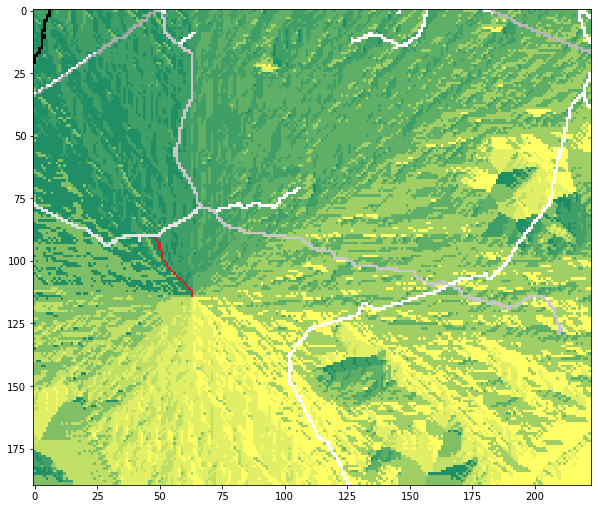

In [91]:
plt.figure(figsize = (10,10))
im1 = plt.imshow(tb_array,cmap=plt.cm.summer)
im2 = plt.imshow(arrPipes,cmap=plt.cm.binary)
im3 = plt.imshow(arrLCP_masked,cmap=plt.cm.Set1)

In [ ]:
cd_array[rowMin,colMin]

In [ ]:
#Compute the LCP from that location to the nearest pipe
mcpConnect = graph.MCP_Connect(arrStack[x])

In [ ]:
mcpConnect.create_connection()

In [ ]:
#Remove that layer from the stack
arrStack_0 = np.delete(arrStack,x,axis=0)
arrStack_0.shape

In [ ]:
#Get the next min
allMin = np.amin(arrStack_0)
x,y,z = np.where(arrStack == allMin)
print("The min value ({}) is in layer {}".format(allMin,x))